**IMPORTS & SETUP**

In [ ]:
import pandas as pd
import numpy as np
import requests
import joblib
import matplotlib.pyplot as plt
from collections import Counter

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


**LOAD & CLEAN DATA**

In [2]:
df  = pd.read_csv("combined.csv")
df.drop_duplicates(inplace=True) # Remove duplicate rows
df["years_of_experience"] = pd.to_numeric(df["years_of_experience"], errors="coerce").fillna(0) # Clean numeric columns

In [ ]:
text_columns = [
    "education_degree", "education_institution", 
    "total_skills", "certifications", 
    "city", "state"
]

for col in text_columns:
    df[col] = df[col].fillna("Unknown").astype(str)

In [4]:
# Clean up
df.fillna("Unknown", inplace=True)

In [6]:
mapping = {
    'ml_engineer':'ML_Eng', 'ml_engineers':'ML_Eng',
    'data_scientists':'DS', 'data_analysts':'DA',
    'business_analyst_Final':'BA', 
    'businees_intelligence_developerss':'BI_Dev',
    'backendFinal':'Backend_Dev', 'frontendFinal':'Frontend_Dev',
    'fullstackFinal':'Fullstack_Dev', 'mobiledevFinal':'Mobile_Dev',
    'blockchain_developers':'Blockchain_Dev', 'web3_developers':'Web3_Dev',
    'security_analyst':'Security_Analyst', 'mlopss':'MLOps_Eng'
}

df['profile_type'] = df['profile_type'].replace(mapping)


**FEATURE PREPROCESSING**

In [69]:
y = df["profile_type"]
X = df[[
    "years_of_experience", "education_degree", "education_institution",
    "total_skills", "certifications", "city", "state"
]]

In [70]:
print(type(X))  # Should output: <class 'pandas.core.frame.DataFrame'>
print(X.columns)


<class 'pandas.core.frame.DataFrame'>
Index(['years_of_experience', 'education_degree', 'education_institution',
       'total_skills', 'certifications', 'city', 'state'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature groups
numeric_features = ["years_of_experience"]
categorical_features = ["education_degree", "education_institution", "city", "state" , "skill_cluster"]

# Separate text transformers
text_transformer_skills = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(stop_words='english', max_features=300)) 
])
text_transformer_certs = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(stop_words='english', max_features=200))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("skills", text_transformer_skills, "total_skills"),
        ("certs", text_transformer_certs, "certifications"),
    ]
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42,class_weight="balanced"))
])

# Split + Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

              BA       0.72      0.73      0.73        56
          BI_Dev       0.76      0.92      0.83       103
     Backend_Dev       0.67      0.78      0.72        95
  Blockchain_Dev       0.00      0.00      0.00        11
              DA       0.00      0.00      0.00        11
              DS       0.00      0.00      0.00         9
    Frontend_Dev       0.25      0.27      0.26        97
   Fullstack_Dev       0.04      0.03      0.04        90
       MLOps_Eng       0.80      0.11      0.20        70
          ML_Eng       0.71      0.97      0.82       203
      Mobile_Dev       0.90      0.86      0.88        81
Security_Analyst       0.94      0.89      0.91        81
        Web3_Dev       0.00      0.00      0.00         9
  data_engineers       0.50      0.17      0.25         6

        accuracy                           0.64       922
       macro avg       0.45      0.41      0.40       922
    weighted

In [74]:
df.head()

,current_position,current_company,years_of_experience,total_skills,education_degree,education_institution,certifications,city,state,country,profile_type,skills_emb,skill_cluster
0,ML Engineer,Adobe,11.0,"Matlab, Electronics, C, C++, Electrical Engine...",Bachelor of Engineering (BE),Anna University,Unknown,Bengaluru,Karnataka,India,ML_Eng,"[-0.04844175, -0.0057044844, -0.00366883, -0.0...",4
1,Machine Learning Engineer,Sarvam,7.0,"Artificial Intelligence (AI), Machine Learning...",BSc - Bachelor of Science,"St. Stephen's College, Delhi",4-Week Virtual Internship Program on Generativ...,Bengaluru,Karnataka,India,ML_Eng,"[-0.035300754, 0.011429758, -0.0013743709, 0.0...",4
2,Python Software Developer,Wipzent,3.1,"Artificial Intelligence (AI), Django, Pandas (...",Bsc in data science,Techno India University,Unknown,Bengaluru,Karnataka,India,ML_Eng,"[-0.05864422, -0.0032778624, -0.0044696354, 0....",4
3,Machine Learning Engineer,Smart Data Solutions,9.2,"Semantic Search, Model Selection, Decision-Mak...",Predictive Analytics for Business,Udacity,"SQL (Basic) Certificate, Databases for Develop...",Chennai,Tamil Nadu,India,ML_Eng,"[-0.09126565, -0.018919256, -0.009689967, 0.04...",4
4,Director - Applied AI,Krutrim,15.6,"Coaching, Responsible AI, Analytical Skills, T...",Doctor of Philosophy (Ph.D.),Tampere University,"Neural Networks for Machine Learning, Machine ...",Bengaluru,Karnataka,India,ML_Eng,"[-0.06426062, -0.013957148, -0.010004171, 0.00...",4


In [8]:
numeric_features = ["years_of_experience"]
categorical_features = ["education_degree", "education_institution", "city", "state"]

**EMBEDDINGS FOR SKILL CLUSTERING**

In [22]:
OLLAMA_URL = "http://localhost:11434/api/embed"
MODEL_NAME = "bge-m3"

def embed_texts(texts):
    """Embed text list using local Ollama API."""
    r = requests.post(OLLAMA_URL, json={"model": MODEL_NAME, "input": texts})
    r.raise_for_status()
    return np.array(r.json()["embeddings"])

print("\n🧬 Generating embeddings for skills...")
df["skills_emb"] = embed_texts(df["total_skills"].tolist()).tolist()


🧬 Generating embeddings for skills...


**FIND OPTIMAL NUMBER OF CLUSTERS (K)**

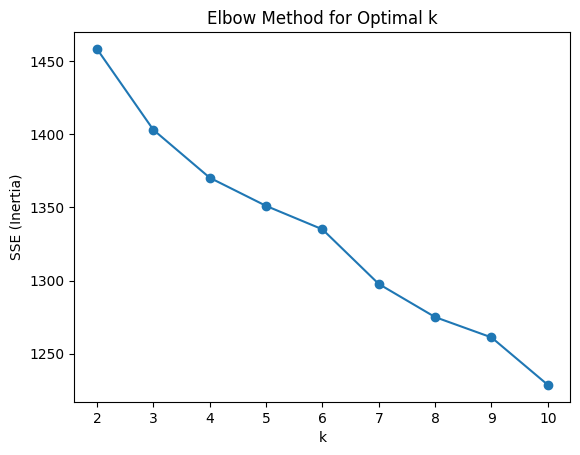

k=2, silhouette=0.077
k=3, silhouette=0.055
k=4, silhouette=0.040
k=5, silhouette=0.036
k=6, silhouette=0.034
k=7, silhouette=0.046
k=8, silhouette=0.040
k=9, silhouette=0.039
k=10, silhouette=0.048


In [47]:
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(df['total_skills'])
X = np.vstack(df["skills_emb"])   # ✅ KMeans trained on embeddings


# Elbow Method
sse = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k}, silhouette={score:.3f}")


**TRAIN FINAL KMEANS MODEL**

In [55]:
kmeans = KMeans(n_clusters=6, random_state=42)
df["skill_cluster"] = kmeans.fit_predict(X)

print("\n📊 Cluster distribution:")
print(df["skill_cluster"].value_counts())

# Save model for later use
joblib.dump(kmeans, "models/skill_clusters2.joblib")
print("💾 Model saved as models/skill_clusters2.joblib")



📊 Cluster distribution:
skill_cluster
0    1054
4     792
3     734
5     725
2     696
1     605
Name: count, dtype: int64
💾 Model saved as models/skill_clusters2.joblib


**TOP SKILLS IN EACH CLUSTER**

In [56]:
for i in range(6):
    cluster_data = df[df["skill_cluster"] == i]
    skills = ", ".join(cluster_data["total_skills"].values)
    skill_list = [s.strip().lower() for s in skills.split(",")]
    top_skills = Counter(skill_list).most_common(10)
    print(f"\n🔥 Cluster {i} — Top Skills:")
    for skill, count in top_skills:
        print(f"  {skill}: {count}")


🔥 Cluster 0 — Top Skills:
  sql: 527
  microsoft excel: 418
  microsoft power bi: 390
  data analysis: 352
  communication: 323
  analytical skills: 322
  tableau: 292
  data visualization: 282
  problem solving: 248
  microsoft office: 241

🔥 Cluster 1 — Top Skills:
  javascript: 353
  java: 318
  cascading style sheets (css): 292
  html: 289
  git: 262
  problem solving: 228
  sql: 223
  communication: 221
  react.js: 220
  object-oriented programming (oop): 211

🔥 Cluster 2 — Top Skills:
  python (programming language): 567
  machine learning: 546
  sql: 441
  deep learning: 403
  natural language processing (nlp): 391
  data science: 368
  data analysis: 351
  artificial intelligence (ai): 327
  amazon web services (aws): 315
  large language models (llm): 314

🔥 Cluster 3 — Top Skills:
  javascript: 696
  cascading style sheets (css): 612
  react.js: 592
  html: 475
  html5: 440
  node.js: 330
  front-end development: 312
  git: 283
  typescript: 273
  web development: 226

🔥 Clu

**VISUALIZE CLUSTERS (PCA 2D)**

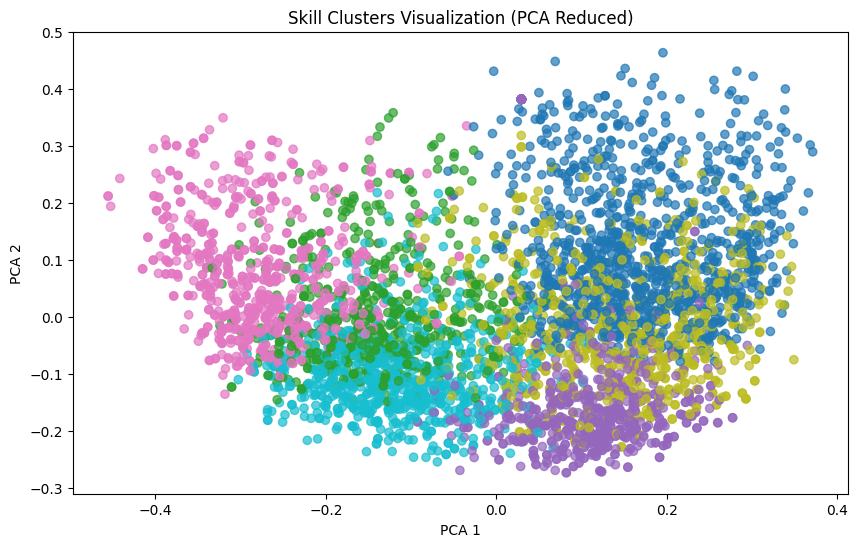

In [57]:
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=df["skill_cluster"], cmap='tab10', alpha=0.7)
plt.title("Skill Clusters Visualization (PCA Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

**SKILL RECOMMENDER (TF-IDF + COSINE SIMILARITY)**

In [60]:
# Fit TF-IDF on your skill column
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['total_skills'])

def recommend_skills(input_skills, top_n=10):
    """
    Recommend new skills by comparing input with similar profiles.
    Returns a clean list of top_n skill recommendations.
    """
    # Vectorize the input
    input_vec = tfidf.transform([input_skills])
    
    # Compute cosine similarity with all profiles
    sims = cosine_similarity(input_vec, X_tfidf).flatten()
    
    # Get top 5 similar profiles
    similar_profiles = df.iloc[sims.argsort()[-5:][::-1]]
    
    # Combine all skills from similar profiles
    all_related_skills = []
    for skills in similar_profiles['total_skills']:
        # Split on comma and strip extra spaces
        all_related_skills.extend([s.strip() for s in skills.split(",")])
    
    # Lowercase everything for comparison
    input_terms = set([s.strip().lower() for s in input_skills.split(",")])
    all_terms = set([s.lower() for s in all_related_skills])
    
    # Remove already known skills
    recommended = list(all_terms - input_terms)
    
    # Capitalize skill names nicely
    recommended = [s.title() for s in recommended]
    
    # Return top_n
    return recommended[:top_n]


**TEST WITH NEW PROFILE**

In [61]:
new_profile = {
    "total_skills": "Python, TensorFlow, Deep Learning, Machine Learning, NLP, Data Science"
}

# Embed new profile
new_emb = embed_texts([new_profile["total_skills"]])[0]
cluster_id = kmeans.predict([new_emb])[0]

print(f"\n🧬 New profile belongs to cluster: {cluster_id}")

# Show similar profiles
print("\n🎯 Similar profiles in this cluster:")
print(df[df["skill_cluster"] == cluster_id][["current_position", "total_skills"]].head(5))

# Recommend new skills
print("\n💡 Recommended new skills:")
print(recommend_skills(new_profile["total_skills"]))



🧬 New profile belongs to cluster: 4

🎯 Similar profiles in this cluster:
            current_position  \
0                ML Engineer   
1  Machine Learning Engineer   
2  Python Software Developer   
3  Machine Learning Engineer   
4      Director - Applied AI   

                                        total_skills  
0  Matlab, Electronics, C, C++, Electrical Engine...  
1  Artificial Intelligence (AI), Machine Learning...  
2  Artificial Intelligence (AI), Django, Pandas (...  
3  Semantic Search, Model Selection, Decision-Mak...  
4  Coaching, Responsible AI, Analytical Skills, T...  

💡 Recommended new skills:
['Keras', 'Statistical Data Analysis', 'Large Language Models (Llm)', 'Data Analysis', 'Amazon Web Services (Aws)', 'Cloud Computing', 'Software Development', 'C (Programming Language)', 'C++', 'Java']
